# Inventory Days

You are tasked with predicting how long the cars in the dataset ```test_cars.csv``` will remain in inventory (Days in Inventory or DI) before being sold. To do so, you must review the code used to generate a Machine Learning model of the historical data in ```train_cars.csv``` and generate a table of predictions for stakeholders to use with the same format as ```sample_submission.csv```. This prediction is incredibly important to the business and even a 1% improvement can have a large impact on margins. 

Sample code is provided that was written by another department but the stakeholders who are using the predictions of how long a car will stay in inventory have complained that:

1) The analysis presented to them (see graph in the notebook) gave them the impression that the model was highly accurate but they are finding that it consistently underestimates DI and error is higher than expected.

2) When they reviewed the code they did not understand what each line of code was doing or how to fix it

3) They believe there is other information that might be useful for predicting inventory days and would like brief summary of how to improve the model in the future

The goal of this project is to address the stakeholders' concerns and build a model that they can trust. The dataset is 100% generated synthetically, however the challenge is very similar to one you might face in some company.

To complete the challenge send a finished Notebook as well as a submissions.csv file with your predictions from the ```test_cars.csv```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

# Code to Review

## Loading data

In [2]:
#Carga la base de datos de autos en el cual se describen propiedades generales de los mismos
skus = pd.read_csv('car_type_characteristics.csv')

#Muestra el tipo de datos por columnas es importante para evitar errores!
print(skus.dtypes)

#muestra una porcion de datos 
skus.head(10)

car_type         object
average_price     int64
transmission     object
body_type        object
dtype: object


,car_type,average_price,transmission,body_type
0,GMC_Sierra_2009,706981,Automatic,Sedan
1,Ford_Edge_2014,868193,Automatic,Sedan
2,Honda_City_2018,671272,Manual,SUV
3,Renault_Twizy_2019,204486,Automatic,Sedan
4,Giant_Giant GF-8_2008,701787,Manual,Sedan
5,Nissan_Tsuru_2009,505127,Automatic,SUV
6,Ford_Focus_2018,680265,Automatic,SUV
7,Audi_A3 Sportback_2010,618739,Manual,Coupe
8,Volkswagen_Gol_2011,912348,Automatic,SUV
9,Mitsubishi_Outlander_2016,195169,Manual,Coupe


In [3]:
#Carga la base de datos de autos que en algun momento pudieron estar o estan en nuestro garage
avalaible_cars = pd.read_csv('cars.csv')

#Muestra el tipo de datos por columnas es importante para evitar errores!
print(avalaible_cars.dtypes)

#Esta linea de codigo es incorrecta, pues al revisar el tipo de aquellas columnas que pueden
#considerarse como un string son del tipo object, por lo que hacer este cambio podria introducir
#error al momento de combinar estos dos tipos
#avalaible_cars['car_id'] = avalaible_cars.car_id.astype('string')

#muestra una porcion del historico de coches
avalaible_cars.head(10)

car_id      object
car_type    object
color       object
year         int64
km           int64
dtype: object


,car_id,car_type,color,year,km
0,0,Toyota_Supra_2020,Blue,2020,25848512
1,112,Toyota_Supra_2020,Black,2020,25913421
2,1497,Toyota_Supra_2020,Black,2020,24069281
3,1891,Toyota_Supra_2020,Blue,2020,21828354
4,1955,Toyota_Supra_2020,Black,2020,25620849
5,2435,Toyota_Supra_2020,Blue,2020,19606492
6,2645,Toyota_Supra_2020,White,2020,21322640
7,3640,Toyota_Supra_2020,Black,2020,27858456
8,3743,Toyota_Supra_2020,Red,2020,20518362
9,4405,Toyota_Supra_2020,White,2020,24583516


In [4]:
#Carga la base de datos de autos que NO han sido vendidos para entrenamiento
unsold_cars_train = pd.read_csv('train_cars.csv')

#muestra los tipos de cada columna en este dataset
print(unsold_cars_train.dtypes)

#muestra una porcion de los coches no vendidos
unsold_cars_train.head(10)

day       object
car_id    object
price      int64
sold        bool
dtype: object


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,day,car_id,price,sold
0,2019-02-09,1891,212457,False
1,2019-02-10,1891,212412,False
2,2019-02-11,1891,212367,False
3,2019-02-12,1891,212322,False
4,2019-02-13,1891,212277,False
5,2019-02-14,1891,212232,False
6,2019-02-15,1891,212187,False
7,2019-02-16,1891,212142,False
8,2019-02-17,1891,212097,False
9,2019-02-18,1891,212052,False


In [5]:
#Como el error lo indica existen columnas (col 1) con multiples tipos de datos
#Por lo que es necesario realizar los ajustes necesarios sobre ésta
#para, nuevamente, no caer en error. La inspeccion visual nos dice que estamos trabajando
#con fechas por lo que convertimos la columna day de tipo objet a time
unsold_cars_train['day'] = pd.to_datetime(unsold_cars_train['day'], format='%Y-%m-%d') #los guiones se deben a la estructura de la fecha en el dataset

#nos aseguramos que el cambio se haya realizado correctamente
print(unsold_cars_train.dtypes)

day       datetime64[ns]
car_id            object
price              int64
sold                bool
dtype: object


In [6]:
#Cargamos la base de datos de autos no vendidos para prueba o test
unsold_cars_test = pd.read_csv('test_cars.csv')

#muestra los tipos de cada columna en este dataset
print(unsold_cars_test.dtypes)

#mostramos las primeras diez columnas del conjunto de prueba
unsold_cars_test.head(10)

car_id          int64
first_date     object
first_price     int64
dtype: object


,car_id,first_date,first_price
0,0,2019-08-14,228071
1,1,2019-09-18,240014
2,10,2019-11-08,324066
3,10000,2019-11-07,297417
4,10001,2019-12-31,934590
5,10002,2019-07-28,856547
6,10003,2019-12-28,680810
7,10004,2019-06-08,444335
8,10005,2019-08-15,948759
9,10007,2019-12-28,1037817


In [7]:
#Puesto a que las fechas se trabajan como tipo datetime realizamos el cambio
unsold_cars_test['first_date'] = pd.to_datetime(unsold_cars_test['first_date'], format='%Y-%m-%d') #los guiones se deben a la estructura de la fecha en el dataset

#comprobamos el cambio
print(unsold_cars_test.dtypes)

car_id                  int64
first_date     datetime64[ns]
first_price             int64
dtype: object


# Data cleaning 

En esta seccion se realiza una limpieza de los datos en busqueda de datos faltantes, datos repetidos, datos coruptos con valores NaN u otros

In [8]:
#busca valores NaN, en arrays numericos, NaN o None en arrays de tipo object
# o  NaT en arrays tipo datetime, ademas, busca por strings vacios (como '' o '  ')
#para implementar una solucion rapida debemos crear una lista que contenga cada uno de las bases de datos que leimos anteriormente
data = [skus, avalaible_cars, unsold_cars_train, unsold_cars_test]

#iteramos sobre los dataframes para conocer si existen estos tipos en los conjuntos
for position, dataset in enumerate(data):
    #reemplazamos cualquier cadena de texto que pudiera contener una o mas de una cadena de espacios
    dataset.replace('', np.nan, inplace=True)
    #reemplazamos cualquier cadena de texto que pudiera contener alguna variacion de NaN
    dataset.replace(['nan', 'Nan', 'NAn', 'NAN', 'nAn', 'naN', 'nAN', 'NaN'], np.nan, inplace=True)
    #inicializamos un contador para conocer si existen valores de estos tipos, en caso positivo
    #conocer el dataset con problemas
    count = dataset.isnull().sum().sum()
    print('Hay {} objetos NaN, None o NaT en el dataset cuya posicion en la lista es {}'.format(count, position))

Hay 0 objetos NaN, None o NaT en el dataset cuya posicion en la lista es 0
Hay 1 objetos NaN, None o NaT en el dataset cuya posicion en la lista es 1
Hay 16 objetos NaN, None o NaT en el dataset cuya posicion en la lista es 2
Hay 0 objetos NaN, None o NaT en el dataset cuya posicion en la lista es 3


De aqui que los conjuntos avalaible_cars y unsold_cars contienen valores np.nan.
Observemos en que posicion se encuentran

In [9]:
#Una forma de conocer en que columna se encuentra el valor np.nan es la siguiente
print('Nans en el conjunto_avalaible_cars')
print(avalaible_cars.isnull().sum())
print(50*'#')
print('Nans en el conjunto unsold_cars_train')
print(unsold_cars_train.isnull().sum())

Nans en el conjunto_avalaible_cars
car_id      1
car_type    0
color       0
year        0
km          0
dtype: int64
##################################################
Nans en el conjunto unsold_cars_train
day        0
car_id    16
price      0
sold       0
dtype: int64


Puesto a que los valores NaN se encuentran dentro de la columna car_id, no es posible aplicar un metodo de matematico para predecir su valor. Si bien es cierto que puede asignarse un valor para cada uno de estos, de tal forma que este sea unico, esto podria generar algun problema administrativo, por lo que una solucion seria aclararlo con el encargado y en su caso subsanar este problema. Dado que esta no es nuestra condicion, procederemos a descartarlos. 

In [10]:
#Descartamos los valores que contienen tipos NaN atraves de la funcion dropna de pandas
avalaible_cars.dropna(inplace=True)
unsold_cars_train.dropna(inplace=True)

#dado a que se eliminaron valores es necesario reiniciar los indices de estos dos datasets
avalaible_cars.reset_index(drop=True, inplace=True)
unsold_cars_train.reset_index(drop=True, inplace=True)

In [11]:
#comprobemos si a traves del procedimiento anterior logramos descartar los valores NaN
#iteramos sobre los dataframes para conocer si existen estos tipos en los conjuntos
for position, dataset in enumerate(data):
    #reemplazamos cualquier cadena de texto que pudiera contener una o mas de una cadena de espacios
    dataset.replace('', np.nan, inplace=True)
    #reemplazamos cualquier cadena de texto que pudiera contener alguna variacion de NaN
    dataset.replace(['nan', 'Nan', 'NAn', 'NAN', 'nAn', 'naN', 'nAN', 'NaN'], np.nan, inplace=True)
    #inicializamos un contador para conocer si existen valores de estos tipos, en caso positivo
    #conocer el dataset con problemas
    count = dataset.isnull().sum().sum()
    print('Hay {} objetos NaN, None o NaT en el dataset cuya posicion en la lista es {}'.format(count, position))

Hay 0 objetos NaN, None o NaT en el dataset cuya posicion en la lista es 0
Hay 0 objetos NaN, None o NaT en el dataset cuya posicion en la lista es 1
Hay 0 objetos NaN, None o NaT en el dataset cuya posicion en la lista es 2
Hay 0 objetos NaN, None o NaT en el dataset cuya posicion en la lista es 3


In [12]:
#Buscamos valores duplicados en cada conjunto. Usando el mismo metodo iterativo
for position, dataset in enumerate(data):
    #contamos los duplicados en cada dataset
    duplicates_count = dataset.duplicated().sum()
    #imprimimos los valores encontrados
    print('Hay {} objetos NaN, None o NaT en el dataset cuya posicion en la lista es {}'.format(duplicates_count, position))

Hay 0 objetos NaN, None o NaT en el dataset cuya posicion en la lista es 0
Hay 0 objetos NaN, None o NaT en el dataset cuya posicion en la lista es 1
Hay 0 objetos NaN, None o NaT en el dataset cuya posicion en la lista es 2
Hay 0 objetos NaN, None o NaT en el dataset cuya posicion en la lista es 3


De este pequeño analisis sabemos que los conjuntos de datos presentaban valores NaN o None o NaT o strings vacios. Sin embargo, fue posible subsanar dicho problema. Por otro lado, no se encontraron muestras duplicadas.

Al cargar los datos nos dimos cuenta de que el tipo de las columnas difieren entre algunos datasets, por lo que es necesario igualarlos.
Seguiremos el siguiente esquema con base en buenas practicas de programacion:
* car_type: string
* average_price: int64
* transmission: string
* body_type: string
* car_id: int64
* color: string
* year: int64	
* km: int64
* day: datetime
* price: int64
* sold: boolean
* first_date: datetime
* first_price: int64

In [13]:
#dataset skus
skus['car_type'] = skus.car_type.astype('string')
skus['transmission'] = skus.transmission.astype('string')
skus['body_type'] = skus.body_type.astype('string')
print(skus.dtypes)

car_type         string
average_price     int64
transmission     string
body_type        string
dtype: object


In [14]:
#dataset avalaible_cars
avalaible_cars['car_id'] = avalaible_cars['car_id'].astype('int64')
avalaible_cars['car_type'] = avalaible_cars.car_type.astype('string')
avalaible_cars['color'] = avalaible_cars.color.astype('string')
print(avalaible_cars.dtypes)

car_id       int64
car_type    string
color       string
year         int64
km           int64
dtype: object


In [15]:
#dataset unsold_cars_train
unsold_cars_train['car_id'] = unsold_cars_train['car_id'].astype('int64')
print(unsold_cars_train.dtypes)

day       datetime64[ns]
car_id             int64
price              int64
sold                bool
dtype: object


In [16]:
print(unsold_cars_test.dtypes)

car_id                  int64
first_date     datetime64[ns]
first_price             int64
dtype: object


Se comprobo, visualmente, que cada dataset no haya sido modificado debido a un error de dedo. empleando el metodo .head(). Estas lineas de codigo se omiten para no complicar la lectura del codigo.

De la inspeccion visual vemos que las bases de datos avalaible_cars y skus, las cuales contienen una columna del tipo car_type, cuya estructura parece seguir la siguiente marca_modelo_año. Puesto a que el conjunto avalaible cars ya cuenta con una columna para especificar el año, este dato es irrelevante, y si esta se considera como variable categorica, entonces, dicha variable categorica sera diferente para un auto con especificaciones marca_modelo_año-1 a un auto con especificaciones marca_modelo_año+1 etc, lo cual generará confusion y separará incorrectamente a dos o más autos que comparten la misma marca y modelo, de esta forma es necesario retirar de car?type esta ultima especificacion, ademas un analisis más completo podria realizarse al separar marca y modelo y tratarlas como variables independientes, este ultimo caso lo estudiaremos en las propuestas.

data = [skus, avalaible_cars]
#iteramos sobre los dataframes para eliminar el año en la descripcion de car_type
for dataset in data:
    #reemplazamos cualquier cadena de texto que contenga la estructura _numero, que es el caso _año
    #unicamente en la columna car_type
    dataset['car_type'] = dataset['car_type'].str.replace('_\d+', '', regex=True)

In [17]:
#nos aseguramos que el cambio se haya realizado correctamente
skus.head(5)

,car_type,average_price,transmission,body_type
0,GMC_Sierra_2009,706981,Automatic,Sedan
1,Ford_Edge_2014,868193,Automatic,Sedan
2,Honda_City_2018,671272,Manual,SUV
3,Renault_Twizy_2019,204486,Automatic,Sedan
4,Giant_Giant GF-8_2008,701787,Manual,Sedan


In [18]:
avalaible_cars.head(5)

,car_id,car_type,color,year,km
0,0,Toyota_Supra_2020,Blue,2020,25848512
1,112,Toyota_Supra_2020,Black,2020,25913421
2,1497,Toyota_Supra_2020,Black,2020,24069281
3,1891,Toyota_Supra_2020,Blue,2020,21828354
4,1955,Toyota_Supra_2020,Black,2020,25620849


Ahora, puesto que no sabemos si existen errores de dedo, en cuanto todas los datos que constan de cademas. Por sanidad, transformaremos todas las cadenas a lowercase y ademas eliminaremos todos los espacios, pues pueden existir al menos dos registros como los siguientes, ToYota_Supra y Toyota_Supra, y/o variaciones, que al momento de transformar estas variables categoricas podrian resultar en "clases" o asignaciones diferentes, lo cual sería incorrecto

In [19]:
#Para el dataset skus, definimos una lista con los nombres de las columnas con valores
#categoricos, con el fin de iterar sobre estos
categorical_columns_data = ['car_type', 'transmission', 'body_type']
#iteramos sobre dicho dataset
for column in categorical_columns_data:
    #convertimos a lowercase
    skus[column] = skus[column].str.lower()
    #removemos todos los espacios
    skus[column] = skus[column].str.replace('\s+', '', regex=True)

In [20]:
#verificamos el cambio
skus.head(5)

,car_type,average_price,transmission,body_type
0,gmc_sierra_2009,706981,automatic,sedan
1,ford_edge_2014,868193,automatic,sedan
2,honda_city_2018,671272,manual,suv
3,renault_twizy_2019,204486,automatic,sedan
4,giant_giantgf-8_2008,701787,manual,sedan


In [21]:
#Para el dataset avalaible_cars, definimos una lista con los nombres de las columnas con valores
#categoricos, con el fin de iterar sobre estos
categorical_columns_data = ['car_type', 'color']
#iteramos sobre dicho dataset
for column in categorical_columns_data:
    #convertimos a lowercase, usando la funcion str.lower()
    avalaible_cars[column] = avalaible_cars[column].str.lower()
    #removemos todos los espacios, usando la funcion str.replace()
    avalaible_cars[column] = avalaible_cars[column].str.replace('\s+', '', regex=True)

In [22]:
#verificamos el cambio
avalaible_cars.head(5)

,car_id,car_type,color,year,km
0,0,toyota_supra_2020,blue,2020,25848512
1,112,toyota_supra_2020,black,2020,25913421
2,1497,toyota_supra_2020,black,2020,24069281
3,1891,toyota_supra_2020,blue,2020,21828354
4,1955,toyota_supra_2020,black,2020,25620849


In [23]:
#Corroboremos ahora que las columnas que contengan informacion del precio, no exista ninguna
#con valor cero o menor que cero, pues en teoria un auto no puede ser vendido a 0 pesos o dolares o
# tener un precio negativo
print('En el dataset skus hay {} valores que son 0 ó menores que 0'.format((skus['average_price'] <= 0).sum()))
print('En el dataset unsold_cars_train hay {} valores que son 0 ó menores que 0'.format((unsold_cars_train['price'] <= 0).sum()))
print('En el dataset unsold_cars_test hay {} valores que son 0 ó menores que 0'.format((unsold_cars_test['first_price'] <= 0).sum()))

En el dataset skus hay 0 valores que son 0 ó menores que 0
En el dataset unsold_cars_train hay 0 valores que son 0 ó menores que 0
En el dataset unsold_cars_test hay 0 valores que son 0 ó menores que 0


In [24]:
#Corroboremos ahora que la columna que contiene informacion del año en el data set avalaible_cars
#no sea menor que 1886, pues en dicho año fue el año del primer automovil con motor de combustion
print('En el dataset avalaible_cars[year] hay {} valores que son menores que 1886'.format((avalaible_cars['year'] < 1886).sum()))

En el dataset avalaible_cars[year] hay 0 valores que son menores que 1886


# Data Preparation

In [25]:
# juntemos la informacion contenida en la base de datos que describe propiedades generales 
# de cada auto (skus), con la informacion de la base de datos que describe que la informacion
#de los autos que en algun momento pudieron estar o estan en nuestro garage (avalaible_cars)
#a traves de una caracteristica comun (en los datasets) que es la marca, modelo y año de cada auto.
car_information = pd.merge(avalaible_cars, skus, on='car_type', how='left')

In [26]:
car_information.head(10)

,car_id,car_type,color,year,km,average_price,transmission,body_type
0,0,toyota_supra_2020,blue,2020,25848512,194799,manual,sedan
1,112,toyota_supra_2020,black,2020,25913421,194799,manual,sedan
2,1497,toyota_supra_2020,black,2020,24069281,194799,manual,sedan
3,1891,toyota_supra_2020,blue,2020,21828354,194799,manual,sedan
4,1955,toyota_supra_2020,black,2020,25620849,194799,manual,sedan
5,2435,toyota_supra_2020,blue,2020,19606492,194799,manual,sedan
6,2645,toyota_supra_2020,white,2020,21322640,194799,manual,sedan
7,3640,toyota_supra_2020,black,2020,27858456,194799,manual,sedan
8,3743,toyota_supra_2020,red,2020,20518362,194799,manual,sedan
9,4405,toyota_supra_2020,white,2020,24583516,194799,manual,sedan


In [27]:
car_information.sort_values('car_id')

,car_id,car_type,color,year,km,average_price,transmission,body_type
0,0,toyota_supra_2020,blue,2020,25848512,194799,manual,sedan
34,1,volkswagen_passat_2008,white,2008,14279745,230948,automatic,suv
58,2,volkswagen_transporter_2014,red,2014,27441875,428016,automatic,sedan
84,3,nissan_tiida_2015,white,2015,28416987,689138,automatic,sedan
115,4,mitsubishi_outlander_2009,black,2009,42857477,992179,automatic,sedan
...,...,...,...,...,...,...,...,...
5413,19995,nissan_marchcargo_2020,blue,2020,38925068,284831,automatic,suv
15409,19996,chevrolet_volt_2017,black,2017,12271565,818115,automatic,sedan
15680,19997,mercedesbenz_sprinterchasiscabinal4_2014,white,2014,27080976,730215,automatic,sedan
19129,19998,mercedesbenz_clasegl_2016,black,2016,38944743,775975,automatic,sedan


In [28]:
car_information['car_type'] = car_information['car_type'].str.replace('_\d+', '', regex=True)
car_information

,car_id,car_type,color,year,km,average_price,transmission,body_type
0,0,toyota_supra,blue,2020,25848512,194799,manual,sedan
1,112,toyota_supra,black,2020,25913421,194799,manual,sedan
2,1497,toyota_supra,black,2020,24069281,194799,manual,sedan
3,1891,toyota_supra,blue,2020,21828354,194799,manual,sedan
4,1955,toyota_supra,black,2020,25620849,194799,manual,sedan
...,...,...,...,...,...,...,...,...
19994,16468,volvo_s80,black,2014,14232987,142081,automatic,suv
19995,16971,volvo_s80,black,2014,18144875,142081,automatic,suv
19996,17013,volvo_s80,red,2014,16447711,142081,automatic,suv
19997,18235,volvo_s80,red,2014,11665859,142081,automatic,suv


Recordando el funcionamiento de left outer join de SQL (misma funcion que pd.merge(how='left')), puesto a que consideramos el dataset avalaible_cars como un subconjunto del dataset general skus, entonces, suponiendo esto y que no hay error de captura en el dataset skus, el dataser car_information no debe contener ningun valor NaN en las columnas correspondientes a skus.
Comprobemos esto antes de proceder

In [29]:
print('Hay {} objetos NaN, None o NaT en el dataset car_information'.format(car_information.isnull().sum().sum()))

Hay 0 objetos NaN, None o NaT en el dataset car_information


In [30]:
#Procedemos a obtener un conjunto de entrenamiento y prueba a partir del dataset cars_information
#refeerenciamos los valores id de los carros contenidos en el dataset unsold_cars_train
car_ids_train = unsold_cars_train.car_id

#creamos una lista para copiar los valores anteriores (id carros)
car_information_ids_train = []

#procedemos a copiarlos mediante un ciclo for
#itera sobre toda la longitud del dataset unsold_cars_train
for i in range(len(unsold_cars_train)):
    #copia los valores mediante un append
    car_information_ids_train.append(car_ids_train[i])
    
#procedemos a crear el conjunto de entrenamiento esto a traves de los identificadores (car_id)
#presentes en car_information bajo la condicion de que dichos identificadores se encuentren
#tambien en los identificadores del conjunto unsold_cars_train
car_info_train = car_information[car_information.car_id.isin(car_information_ids_train)]

#Para crear el conjunto de prueba hacemos uso de la misma condicion pero negada, es decir,
#el conjunto de prueba consta de todos los identificadores (car_id) presentes en el conjunto
#car_information siempre y cuando éstos no se encuentren en el conunto conjunto unsold_cars_train
#el simbolo ~ representa negacion del postulado
car_info_test = car_information[~car_information.car_id.isin(car_information_ids_train)]

#mostramos los primeros 10 elementos del conjunto de entrenamiento recien construido:
car_info_train.head(10)

,car_id,car_type,color,year,km,average_price,transmission,body_type
3,1891,toyota_supra,blue,2020,21828354,194799,manual,sedan
6,2645,toyota_supra,white,2020,21322640,194799,manual,sedan
8,3743,toyota_supra,red,2020,20518362,194799,manual,sedan
11,5083,toyota_supra,black,2020,27073159,194799,manual,sedan
15,7156,toyota_supra,red,2020,21071772,194799,manual,sedan
19,8162,toyota_supra,blue,2020,24400569,194799,manual,sedan
22,11436,toyota_supra,red,2020,21080514,194799,manual,sedan
24,13253,toyota_supra,black,2020,24149145,194799,manual,sedan
30,17495,toyota_supra,black,2020,18865426,194799,manual,sedan
32,19780,toyota_supra,white,2020,26141271,194799,manual,sedan


In [31]:
#Para conocer la cantidad de tiempo que un auto ha pasado antes de ser vendido
# se usa la funcion de agregacion groupby.('car_id').sold, la cual genera grupos
#de valores booleanos (sold) de acuerdo con car_id, es decir cada grupo, correspondera
#a un único auto (car_id), el cual contendrá los valores sold para dicho unico car_id.
#puesto a que un coche que ya ha sido vendido puede adquirir en una sola fecha el valor
#True, la cual será la más reciente, es posible realizar un ordenamiento de las fechas
#de mas antigua a mas reciente al conocer la condicion de sold. Esto se realiza a traves
#de la funcion tansform('max') == condicion
car_series = unsold_cars_train[unsold_cars_train.groupby('car_id').sold.transform('max') == True]


#el agrupamiento a traves de group by no altera los valores de las otras columnas.
#una vez que se tiene un conjunto agrupado por car_id y ordenado por fecha para cada id
#es posible contar cuantos dias un auto pasó en el garage antes de ser vendido
#para ello se realizan grupos cuyos valores contendran la cuenta de los días para cada id.
#para contar los dias se aplica unicamente el conteo de filas en cada grupo, pues, suponemos
#que el registro fue rellenado cada día, esto se realiza atraves de la funcion count()
#la funcion reset index permite regresar al typo pandas.DataFrame, ya que la funcion
#de agregacion regresa un typo pandas.Series
car_series_days = car_series.groupby('car_id').day.count().reset_index()

In [32]:
#mostramos los primeros diez elementos de ambos conjuntos recien creados
car_series.head(10)

,day,car_id,price,sold
0,2019-02-09,1891,212457,False
1,2019-02-10,1891,212412,False
2,2019-02-11,1891,212367,False
3,2019-02-12,1891,212322,False
4,2019-02-13,1891,212277,False
5,2019-02-14,1891,212232,False
6,2019-02-15,1891,212187,False
7,2019-02-16,1891,212142,False
8,2019-02-17,1891,212097,False
9,2019-02-18,1891,212052,False


In [33]:
car_series_days.head(10)

,car_id,day
0,6,13
1,8,38
2,11,12
3,12,10
4,14,11
5,17,38
6,25,19
7,31,19
8,34,1
9,37,11


In [34]:
#dado a que se eliminaron valores es necesario reiniciar los indices de estos dos datasets
car_series.reset_index(inplace=True, drop=True)
#Comprobemos si la regla de registro para cada auto se cumplio diariamente, en caso contrario
#debemos modificar los valores de day en la tabla car_series_days
#crea una lista y una variable dummy para contar aquellos autos para los cuales solo tienen
#un dia de antiguedad, es decir llegaron hoy.
new_cars = 0
id_new_cars = []
#itera sobre los indices unicos de los autos car_id
for id_cars in np.unique(car_series['car_id'].values):
    #obten las posiciones relativas en el dataset original, esto para poder distinguir y saber
    #que se trata de un auto con un solo id
    positions = np.where(car_series['car_id']==id_cars)[0]
    # si el auto con el identificador especifico tiene dos o mas registros, entonces
    #tiene de antiguedad dos o mas dias, entonces es posible calcular la diferencia
    #de dias entre cada registro
    if positions.shape[0] >= 2:
        #crea un array con todos los registros de dia expecto el primero
        delta1 = car_series['day'][positions[1:]].to_numpy()
        #crea un array con todos los registros de dia expecto el ultimo
        delta2 = car_series['day'][positions[:-1]].to_numpy()
        #calcula la diferencia haciendo uso de estos arrays, que por su construccion
        #nos asegura que en cada posicion se obtiene la resta entre renglones consecutivos
        days_between = (delta1-delta2).astype('timedelta64[D]').astype(np.float32)
        #calcula la media del array de diferencias, si esta media es mayor que 1.0, entonces
        #existe un error en el registro
        mean_days_between = np.mean(days_between)
        # si encuentra un error en el registro imprime este mensaje
        if mean_days_between >= 1.01:
            print('El auto con car_id {} no cumple con la norma de haber sido registrado diariamente'.format(id_cars))
    else:
        ## si el auto con el identificador especifico tiene un solo registro, entonces
        #el auto es nuevo o duro solo un dia con nosotros, si es el caso aumenta el contador y guarda el identificador
        new_cars+=1
        id_new_cars.append(id_cars)
    
if new_cars!=0:
    print('Se encontraron autos nuevos o que al dia de su llegada fueron vendidos')

Se encontraron autos nuevos o que al dia de su llegada fueron vendidos


De esta comprobacion sencilla hemos encontrado informacion relevante: existen coches recien llegados o que el dia de su llegada fueron vendidos.
Puesto a que estamos interesados en un modelo de regresion predictivo, el conjunto de entrenamiento no debe contener muestras para las cuales la informacion no sea suficiente, como es el caso de los autos recien llegados que no han sido vendidos. Supondremos por simplicidad que aquellos autos que tienen al menos un dia aportan informacion relevante. Aunque esta suposicion puede relajarse o hacerse mas restrictiva simplemente cambiando el valor *if positions.shape[0]>=valor (linea 15 de la celda anterior)

Comprobemos ahora, que no existen automobiles, que si existen en el registro, pero que NO han sido vendidos, pues si estos se consideran, se estaría comentiendo un error, ya que estos no deben ser considerados dentro del conjunto de entrenamiento. Recordemos que nuestro fin consiste en modelar la contidad de tiempo que un auto pasa en el garage antes de ser vendido, lo cual implica que cada auto debio haber sido vendido.

In [35]:
#del conjunto car series, construido a partir de los datos de train, extraeremos,
#dos grupos tales que uno de ellos contenga el valor sold = True, mientras que el otro
#tenga valor sold=False, para comprobar que los autos han sido vendidos observaremos
#la cantidad de autos en el grupo con valor sold=True y este lo compararemos con la cantidad
#de identificadores unicos en el mismo registro, es decir la cantidad de autos disponibles de
#acuerdo con su car_id único.

#obtenemos los grupos con valor sold = True y False, al realizar la operacion groupby('sold')
#al conjunto car_series
print(car_series.groupby('sold').size())

sold
False    154637
True       6885
dtype: int64


In [36]:
#la cantidad de autos corresponde al tamaño del grupo True, este valor lo asignamos a una variable
solded_cars =car_series.groupby('sold').size()[1]

#obtengamos la cantidad de identificadores unicos car_id en el conjunto 
#car_series, la busqueda de identificadores unicos se realiza con la funcion np.unique(valores)
cars_quantity = np.unique(car_series['car_id'].values).shape[0]

#comparemos ambas cantidades, en caso de que difieran tendremos que limpiar, nuevamente el conjunto
if (solded_cars == cars_quantity):
    print('La cantidad de autos vendidos y la cantidad de autos en el conjunto car_series, es la misma')
else:
    print('La cantidad de autos vendidos y la cantidad de autos en el conjunto car_series, NO es la misma.'
          ' Proceda a limpiar el conjunto car_series')

La cantidad de autos vendidos y la cantidad de autos en el conjunto car_series, es la misma


## Modeling

Puesto a que se requiere generar un modelo, que prediga la cantidad de tiempo, en días, que un auto permanecerá en el inventario. Nos enfrentamos a un problema de regresión, donde la cantidad en días, variable DI es una cantidad continua no discretizable.
Ahora bien, del tratamiento anterior sabemos que los datos se encuentran limpios y listos para ser aplicados a un modelo de regresion. Por cuestiones comparativas usaremos primero el modelo
de Random Forest Regresion, empleado en el trabajo anteriormente presentado. Ademas exploraremos otras alternativas.

In [37]:
#importamos librerias utiles de scikit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [38]:
#modificamos, copiamos nuestro conjunto car_info_train a modo de que los identificadores funjan
#como indices, esto es especialmente util para relacionar los valores en este conjunto
#con otros conjuntos
X = car_info_train.set_index('car_id')

#puesto a que, como ya vimos en nuestro conjunto de entrenamiento, existen unicamente
#6885 autos unicos, y puesto a que hemos obtenido la cantidad de dias que pasado en nuestro
#garage antes de ser vendidos (dataset car_series_days), es posible "omitir", aquella informacion
#repetitiva, que nos fue util para obtener la cantidad de dias. Entonces, nuestro conjunto de
#entrenamiento en el cual realizaremos regresion, constara de caracteristicas de cada coche en,
#particular. Para descartar dicha info repetitiva y quedarnos unicamente con informacion unica de cada
#auto empleamos la funcion .loc[valor], donde valor corresponde al identificador unico de cada
#auto, el cual por construccion es facilmente localizable en la columna car_id del conjunto
#car_series_days
X = X.loc[car_series_days.car_id]

#imprimamos la longitud o tamaño de este conjunto de entrenamiento
print('El conjunto X, tiene {} columnas y {} filas'.format(X.shape[1], X.shape[0] ))

El conjunto X, tiene 7 columnas y 6885 filas


In [39]:
#modificamos, copiamos nuestro conjunto car_info_test a modo de que los identificadores funjan
#como indices, esto es especialmente util para relacionar los valores en este conjunto
#con otros conjuntos
##empleamos el mismo argumento que con el conjunto X, para descartar informacion repetitiva
#pero usando el conjunto unsold_cars_test y los identificadores car_id
X_test = car_info_test.set_index('car_id').loc[unsold_cars_test.car_id].reset_index()

#La linea en el codigo original
#car_info_test.set_index('car_id').loc[test.car_id].reset_index().drop_duplicates(subset=['car_id']).drop('car_id',axis=1)
#toma el conjunto X_test modificado en la linea 8 de esta celda, resetea los indices, de tal forma
#que estos corran de 0 hasta filas-1 (funcion reset_index()), los indices anteriores se guardan en
#una columna, la cual es eliminada con la funcion drop('car_id',axis=1), finalmente,
#drop_duplicates(subset=['car_id']) elimina filas duplicadas en X_text
#Esta linea de codigo es incorrecta, pues al eliminar el identificador de cada auto car_id, no
#tendremos la posibilidad de relacionarlo con sus respectivas predicciones, lo cual será
#nuestro reporte de clasificacion. Por lo que unicamente nos deshacemos de los duplicados.
X_test = X_test.drop_duplicates(subset=['car_id'])
X_test = X_test.set_index('car_id')

#A partir de X creamos los conjuntos de entrenamiento y validacion, con las proporciones
#80% y 20% respectivamente, estas porciones se toman aleatoriamente de X con la funcion .sample(frac=porcion)
X_train = X.sample(frac=0.8, random_state=2021)
X_train.reset_index(inplace=True)
X.reset_index(inplace=True)
X_val = X.loc[~X.car_id.isin(X_train.car_id)]
X_val = X_val.set_index('car_id')
X_train = X_train.set_index('car_id')
X = X.set_index('car_id')

#Creamos las variables dependientes de cada uno de los autos, estas variables son solamente
#la cantidad de dias, al conjunto de estas variables lo llamaremos Y_train y Y_test
#y ajustaremos los indices a car_id, y se copiamos los dias a sus respectivos conjuntos (train o val)
#con la funcion .loc[conjunto.indice].dias
Y_train = car_series_days.set_index('car_id').loc[X_train.index].day
Y_val = car_series_days.set_index('car_id').loc[X_val.index].day

In [40]:
X_train

,car_type,color,year,km,average_price,transmission,body_type
car_id,,,,,,,
18120,jaguar_xf,red,2016,36801965,911348,automatic,suv
7840,nissan_marchcargo,black,2018,31238676,750353,manual,sedan
613,renault_duster,black,2017,28868359,572061,manual,sedan
17740,chevrolet_traverse,red,2013,20900580,366272,automatic,suv
19398,nissan_tiida,blue,2010,33312619,675368,automatic,sedan
...,...,...,...,...,...,...,...
5828,chevrolet_expressvan,blue,2008,18574424,139965,automatic,truck
11853,jeep_gladiator,blue,2020,10883806,177472,automatic,sedan
2078,renault_kangoo,black,2015,21106489,265664,automatic,sedan


In [41]:
X_val

,car_type,color,year,km,average_price,transmission,body_type
car_id,,,,,,,
11,acura_tlx,orange,2017,22473279,914912,automatic,suv
55,bmw_x5,white,2019,27237164,850541,automatic,coupe
67,bmw_serie6,black,2009,28740411,773609,manual,suv
69,dodge_charger,black,2012,21108702,281675,automatic,truck
77,giant_gf,white,2018,29860796,131531,automatic,suv
...,...,...,...,...,...,...,...
19930,cadillac_srx,black,2011,4975436,124431,automatic,sedan
19933,volkswagen_crafter,red,2012,25979808,216121,automatic,suv
19977,honda_cr-v,white,2011,17353799,167631,automatic,sedan


In [42]:
X

,car_type,color,year,km,average_price,transmission,body_type
car_id,,,,,,,
6,lincoln_mkx,red,2010,4919877,722375,automatic,sedan
8,bmw_x6,blue,2019,27968216,629417,automatic,truck
11,acura_tlx,orange,2017,22473279,914912,automatic,suv
12,bmw_serie5,blue,2014,32025699,638187,automatic,sedan
14,audi_a4,white,2018,29789949,476254,automatic,suv
...,...,...,...,...,...,...,...
19979,dodge_charger,black,2008,21144515,788368,automatic,sedan
19980,hino_serie300616,black,2016,26059824,879018,automatic,coupe
19987,chevrolet_silverado1500v6,blue,2012,16072830,970350,automatic,sedan


In [43]:
#mostramos los primeros 5 elementos de los conjuntos X_train, Y_train
X_train.head(5)

,car_type,color,year,km,average_price,transmission,body_type
car_id,,,,,,,
18120,jaguar_xf,red,2016,36801965,911348,automatic,suv
7840,nissan_marchcargo,black,2018,31238676,750353,manual,sedan
613,renault_duster,black,2017,28868359,572061,manual,sedan
17740,chevrolet_traverse,red,2013,20900580,366272,automatic,suv
19398,nissan_tiida,blue,2010,33312619,675368,automatic,sedan


In [44]:
Y_train.head(5)

car_id
18120    57
7840     35
613      78
17740    24
19398     9
Name: day, dtype: int64

# Mini Visualization

In [45]:
#crea una lista de los valores unicos de los autos disponibles
car_type_list = X_train.car_type.unique()
#selecciona una pequeña porcion de autos unicos
some_cars = [car_type_list[1], car_type_list[45], car_type_list[9],  car_type_list[38], car_type_list[167], car_type_list[138]]
#crea un dataframe a partir de dichos autos unicos seleccionados
visual = X_train.loc[X_train.car_type.isin(some_cars)]
#muestra 10 elementos del nuevo dataframe
visual.sample(10)

,car_type,color,year,km,average_price,transmission,body_type
car_id,,,,,,,
6702,honda_cr-v,white,2019,11659413,976285,manual,suv
10766,honda_odyssey,black,2014,12294448,325355,automatic,sedan
6469,audi_s5,white,2019,23962286,257455,manual,sedan
16840,bmw_serie1,black,2015,38631566,471235,automatic,suv
5739,honda_odyssey,red,2014,16381871,325355,automatic,sedan
19227,honda_odyssey,black,2014,12101455,325355,automatic,sedan
13465,ford_transit,black,2013,33460920,595061,automatic,sedan
12436,bmw_serie1,red,2010,39801588,206482,automatic,sedan
15481,audi_s5,red,2019,20899180,257455,manual,sedan


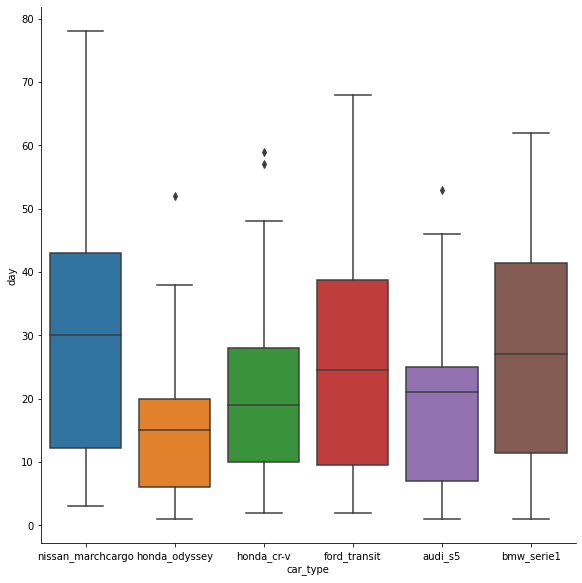

In [46]:
#une visual con Y_train para conocer la cantidad de dias que un auto ha pasado
visual = visual.merge(Y_train, how='left', left_index=True, right_index=True)
#visualiza la relacion modelo - dias antes de ser vendido
sns.catplot(x='car_type', y='day', data=visual, kind='box', height=8);

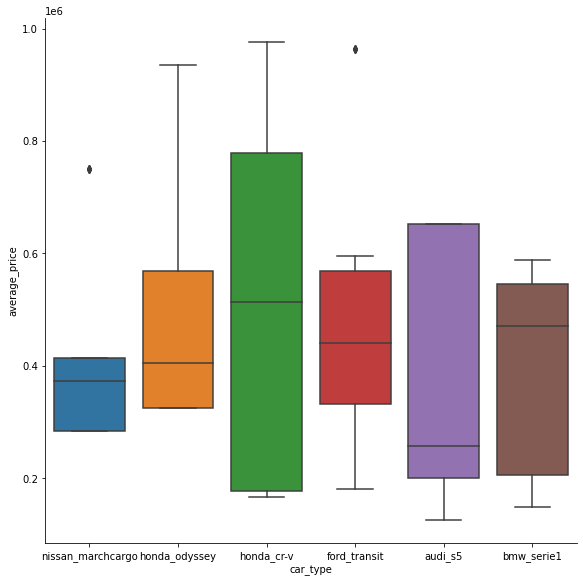

In [47]:
#visualiza la relacion modelo - precio
sns.catplot(x='car_type', y='average_price', data=visual, kind='box', height=8);

Las variables categoricas tales como car_type, color, transmission y #body_type
no pueden ser analizadas directamente por una maquina por lo que deben ser enumeradas
de acuerdo a valores unicos, por ejemplo, suponga que tenemos el sig conjunto de colores
[blanco, rojo, rojo, azul] la transformacion de variables catogoricas asignara un unico valor
 a un unico color, supongamos que lo hacemos asi: azul-> 1, blanco-> 2 y rojo->3, de esta forma
podemos transformar el data set anterior de la siguiente forma [blanco, rojo, rojo, azul] -> [2,3,3,1]
y con ello entrenar el regresor

In [48]:
#Para hacer esto instanciamos la herramienta de scikit LabelEncoder(), la cual puede
#transformar las variables categoricas en numericas de forma automatica
cat_enc = LabelEncoder()

#para poder iterar y transformar las variables presentes en el dataset creamos una
#lista que contiene los nombres de dichas variables, en el codigo original
#el año era tratado como una variable categorica, sin embargo esto no es asi,
#la variable año es discreta y continua, por lo que no lo consideramos en esta
#transformacion
categorical_columns = ['car_type', 'color', 'transmission', 'body_type']

#iteramos sobre las columnas de los conjuntos X_val, X_train y X_test para realizar
#dicha transformacion, siendo estas transformacion realizadas al llamar el metodo 
#fit transform de la clase LabelEncoder() 
for col in categorical_columns:
    X_train[col] = cat_enc.fit_transform(X_train[col])
    X_val[col] = cat_enc.fit_transform(X_val[col])
    X_test[col] = cat_enc.fit_transform(X_test[col])

#se reparo el warning que arrojaba el codigo anterior, relacionado con la dimension
#de los valores pasados a cat_enc, esto se soluciono al eliminar las llaves extras []
# cambiamos de X_test[[col]] a X_test[col]

un comentario con respecto al conjunto que se considera en el codigo original es que en si no se hubiesen quitado los años que estaban contemplados en la informacion car_type, se estaria considerando que un auto marca_modelo_año es diferente a uno cuya informacion sea marca_modelo_año+1 etc, aun cuando se tratase de un auto de la misma marca y modelo.
Este caso ya no se presenta aquí pues hemos retirado el año de los datos presentes en car_type, tal y como se mencionó anteriormente.

In [49]:
#verifiquemos el cambio
X_test.head()

,car_type,color,year,km,average_price,transmission,body_type
car_id,,,,,,,
0,329,1,2020,25848512,194799,1,1
1,345,4,2008,14279745,230948,0,2
10,138,0,2015,29208059,281396,0,1
10000,321,1,2014,11844789,252925,0,2
10001,307,4,2008,34493336,877111,0,1


Puesto a que las variables categoricas pueden variar en cantidades significativas, por ejemplo
typo de carro varian de 0 a almenos 348, estos rangos altos pueden ser problematicos para
cualquier regresor, pues puede sesgar las decisiones de acuerdo a esta variabilidad, para evitar esto, realizamos una Normalizacion sobre los mismos.
La normalizacion esta definida como $$X_{new} = \frac{X_{actual} - X_{min}}{X_{max} - X_{min}}$$

Lo mismo sucede con los valores continuos como año, km y averange price, sin embargo para estos emplearemos estandarizacion de los datos pues estos son continuos y pueden ser considerados como provenientes de una funcion de probabilidad gaussiana.
La estandarizacion esta definida como $$X_{new} = \frac{X_{actual}-\mu}{\sigma}$$, donde $\mu$ es la media y $\sigma$ es la desviacion estandar

In [50]:
#importamos funciones que nos permiten realizar estandarizacion y normalizacion de forma automatica
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#designamos una lista con los nombres de las columnas cuyos valores son continuos para poder iterar
#sobre ellas
numerical_data = ['year', 'km', 'average_price']
#estandarizamos los datos correspondientes a las columnas con valores continuos
for col in numerical_data:
    #definimos y ajustamos un escalador, este escalador define la media y varianza de los valores
    #presentes en la columna actual
    scale = StandardScaler().fit(X_train[[col]])
    X_train[col] = scale.fit_transform(X_train[[col]])
    X_val[col] = scale.transform(X_val[[col]])
    X_test[col] = scale.transform(X_test[[col]])

#escalamos los datos categoricos al iterar sobre sus columnas
for col in categorical_columns:
     #definimos y ajustamos un normalizador, este normalizador obtiene los maximos y minimos de los valores
    #presentes en la columna actual
    norm = MinMaxScaler().fit(X_train[[col]])
    X_train[col] = norm.transform(X_train[[col]])
    X_val[col] = norm.transform(X_val[[col]])
    X_test[col] = norm.transform(X_test[[col]])

## Model Selection

En esta seccion emplearemos 3 modelos diferentes, los cuales han probado ser muy eficientes en cuanto a la regresion en diversos problemas de regresion. Estos modelos son Random Forest Regressor (propuesto originalmente), XGBoost Regressor y SGDRegressor.
Comenzaremos mostrando la propuesta original para posteriormente emplear otro hiperparametro con el mismo modelo, finalmente presentamos los otros dos modelos.

Cabe mencionar que se probaron otros algoritmos regresores muy conocidos, sin embargo, los valores en sus metricas eran mayores que los aquí presentados. Por estas razones y de espacio, no se reportan

In [51]:
#replicamos los resultados del codigo anterior
#instanciamos un random forest regressor, el modelo para ralizar la regresion sobre los datos
#n_estimators corresponde a la cantidad de arboles o trees en el algoritmo. Una cantidad muy baja
#como 1 no es recomendado pues el modelo no obtendra resultados optimos
rf = RandomForestRegressor(n_estimators=1)
#realizamos la regresion con el modelo random forest con 1 tree con los valores X_tarin Y_train
rf.fit(X_train, Y_train)
#obtenemos la prediccion segun el modelo recien entrenado, usando los valores de calidacion X_val
preds = rf.predict(X_val)

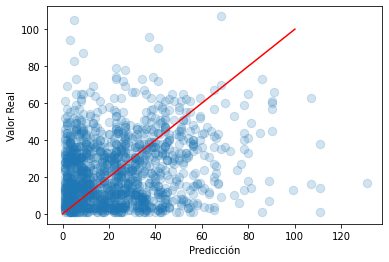

In [52]:
#realizamos una grafica de dispersion donde en el eje X representaran los valores de las
# preds, mientras que el eje Y representara a los valores reales Y_val.
#el valor de alpha corresponde a que tan transparentes se veran los puntos, 0 transparente
#1 opaco. s corresponde al tamaño que tendran los puntos en la grafica
plt.scatter(preds, Y_val, alpha=.2,s=70)
#En esta misma grafica, se grafica una recta con origen en cero y ordenada al origen cero
#esto se hace para comparar los valores reales y de prediccion, un clasificador perfecto
#hará que los puntos se encuentren sobre la linea, sin ninguna distancia que los separe
#esta recta se presenta en color rojo
plt.plot([0,100],[0,100], color='red')
plt.xlabel('Predicción')
plt.ylabel('Valor Real');

In [53]:
#calculamos métricas que nos sugieren la efectividad del ajuste
#MAPE: mean absolute percentage error: estima la distancia promedio entre valores reales y predichos
print(f'MAPE: {((preds - Y_val).abs()/Y_val).mean()}')
# RMSE: root mean squared error: estima la desviación estándar de la varianza inexplicable
print(f'RMSE: {(((preds - Y_val)**2).mean())**.5}')

MAPE: 2.346094823314849
RMSE: 23.94360658497997


In [54]:
#instanciamos un random forest regressor, el modelo para ralizar la regresion sobre los datos
#n_estimators corresponde a la cantidad de arboles o trees en el algoritmo. En esta ocasion
#usamos n_stimators=1000
rf_1 = RandomForestRegressor(n_estimators=100)
#entrenamos o ajustamos nuestro nuevo modelo a los datos de entrenamiento
rf_1.fit(X_train, Y_train)
#realizamos predicciones sobre los datos de validacion
preds_rf_1 = rf_1.predict(X_val)

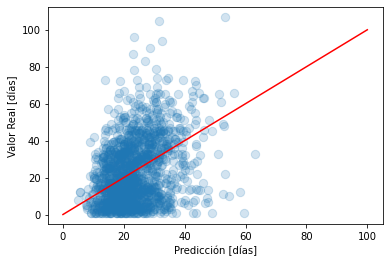

In [55]:
#graficamos los puntos de las predicciones del modelo rf_1 en funcion de los valores
#reales, tal y como se hizo anteriormente
plt.scatter(preds_rf_1, Y_val, alpha=.2, s=70)
#graficamos la recta para poder obtener una idea intuitiva del ajuste
plt.plot([0,100],[0,100], color='red')
plt.xlabel('Predicción [días]')
plt.ylabel('Valor Real [días]');

In [56]:
#calculamos las métricas MAPE y RMSE
print(f'MAPE: {((preds_rf_1 - Y_val).abs()/Y_val).mean()}')
print(f'RMSE: {(((preds_rf_1 - Y_val)**2).mean())**.5}')

MAPE: 2.1196450852656583
RMSE: 17.03923693786892


In [57]:
#instanciamos un random forest regressor, el modelo para ralizar la regresion sobre los datos
#n_estimators corresponde a la cantidad de arboles o trees en el algoritmo. En esta ocasion
#usamos n_stimators=1000
rf_1m = RandomForestRegressor(n_estimators=100)
#entrenamos o ajustamos nuestro nuevo modelo a los datos de entrenamiento
rf_1m.fit(X_train.iloc[:,:4], Y_train)
#realizamos predicciones sobre los datos de validacion
preds_rf_1m = rf_1m.predict(X_val.iloc[:,:4])

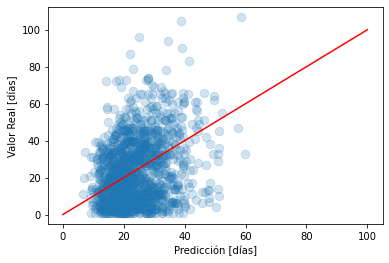

In [58]:
#graficamos los puntos de las predicciones del modelo rf_1 en funcion de los valores
#reales, tal y como se hizo anteriormente
plt.scatter(preds_rf_1m, Y_val, alpha=.2, s=70)
#graficamos la recta para poder obtener una idea intuitiva del ajuste
plt.plot([0,100],[0,100], color='red')
plt.xlabel('Predicción [días]')
plt.ylabel('Valor Real [días]');

In [59]:
#calculamos las métricas MAPE y RMSE
print(f'MAPE: {((preds_rf_1m - Y_val).abs()/Y_val).mean()}')
print(f'RMSE: {(((preds_rf_1m - Y_val)**2).mean())**.5}')

MAPE: 2.152788816010315
RMSE: 17.307408646155725


In [60]:
#importamos librerias que definen una variente del algoritmo XGBoost
from sklearn.ensemble import GradientBoostingRegressor
#definimos el modelo basado en implementaciones de gradientboosting con la misma cantidad de 
#estimadores que el random forest reg (1000) para poder realizar comparacion justa
gbr = GradientBoostingRegressor(n_estimators=100,max_depth=7, alpha=0.1)
#Ajustamos el modelo gbr usando los datos de entrenamiento
gbr.fit(X_train, Y_train)
#realizamos la predicciones sobre el conjunto de validacion
preds_gbr = gbr.predict(X_val)

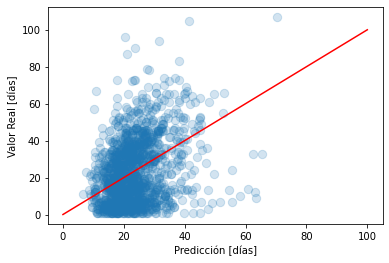

In [61]:
#graficamos los puntos de las predicciones del modelo gbr en funcion de los valores
#reales, tal y como se hizo anteriormente
plt.scatter(preds_gbr, Y_val, alpha=.2, s=70)
#graficamos la recta para poder obtener una idea intuitiva del ajuste
plt.plot([0,100],[0,100], color='red')
plt.xlabel('Predicción [días]')
plt.ylabel('Valor Real [días]');

In [62]:
#calculamos las métricas MAPE y RMSE
print(f'MAPE: {((preds_gbr - Y_val).abs()/Y_val).mean()}')
print(f'RMSE: {(((preds_gbr - Y_val)**2).mean())**.5}')

MAPE: 2.0980699863792447
RMSE: 17.03437426486082


In [63]:
gbr1 = GradientBoostingRegressor(n_estimators=100,max_depth=7, alpha=0.1)
#Ajustamos el modelo gbr usando los datos de entrenamiento
gbr1.fit(X_train.iloc[:,:4], Y_train)
#realizamos la predicciones sobre el conjunto de validacion
preds_gbr1 = gbr1.predict(X_val.iloc[:,:4])

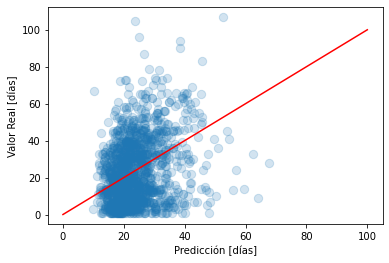

In [64]:
#graficamos los puntos de las predicciones del modelo gbr en funcion de los valores
#reales, tal y como se hizo anteriormente
plt.scatter(preds_gbr1, Y_val, alpha=.2, s=70)
#graficamos la recta para poder obtener una idea intuitiva del ajuste
plt.plot([0,100],[0,100], color='red')
plt.xlabel('Predicción [días]')
plt.ylabel('Valor Real [días]');

In [65]:
#calculamos las métricas MAPE y RMSE
print(f'MAPE: {((preds_gbr1 - Y_val).abs()/Y_val).mean()}')
print(f'RMSE: {(((preds_gbr1 - Y_val)**2).mean())**.5}')

MAPE: 2.1875028729332255
RMSE: 17.25275012529727


In [66]:
#importamos librerias que definen el algoritmo SGD regressor
from sklearn.linear_model import SGDRegressor
#definimos el modelo basado en SGD regressor. La misma cantidad de estimadores no existe en este
#pues no esta basado en arboles de decision
s = SGDRegressor(loss='squared_epsilon_insensitive')
#Ajustamos el modelo s usando los datos de entrenamiento
s.fit(X_train, Y_train)
#realizamos la predicciones sobre el conjunto de validacion
preds_s = s.predict(X_val)

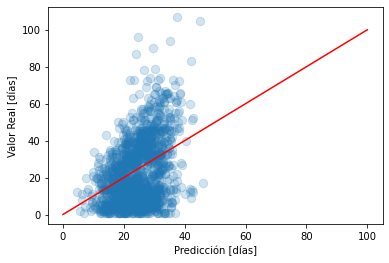

In [67]:
#graficamos los puntos de las predicciones del modelo s en funcion de los valores
#reales, tal y como se hizo anteriormente
plt.scatter(preds_s, Y_val, alpha=.2, s=70)
#graficamos la recta para poder obtener una idea intuitiva del ajuste
plt.plot([0,100],[0,100],color='red')
plt.xlabel('Predicción [días]')
plt.ylabel('Valor Real [días]');

In [68]:
#calculamos las métricas MAPE y RMSE
print(f'MAPE: {((preds_s - Y_val).abs()/Y_val).mean()}')
print(f'RMSE: {(((preds_s - Y_val)**2).mean())**.5}')

MAPE: 2.1790658985339157
RMSE: 16.377115083009667


In [69]:
#Existe una implementacion del algoritmo XGBoost, el cual asegura ser mas rapido que la 
#implementacion de scikit y ademas emplea metodos de regularizacion sobre los arboles para
#evitar el sobreajuste. Esta implementacion se encuentra en la libreria xgboost. La cual a
#continuacion instalamos
!pip install xgboost

In [70]:
#importamos la libreria xgboost
import xgboost
#instanciamos el modelo xgboost, con n_estimators=1000 para realizar comparaciones justas
xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
#Ajustamos el modelo xgb usando los datos de entrenamiento
xgb.fit(X_train, Y_train)
#realizamos la predicciones sobre el conjunto de validacion
preds_xgb = xgb.predict(X_val)

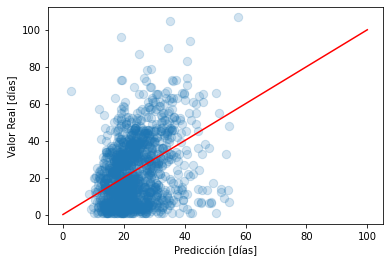

In [71]:
#graficamos los puntos de las predicciones del modelo xgb en funcion de los valores
#reales, tal y como se hizo anteriormente
plt.scatter(preds_xgb, Y_val, alpha=.2, s=70)
#graficamos la recta para poder obtener una idea intuitiva del ajuste
plt.plot([0,100],[0,100], color='red')
plt.xlabel('Predicción [días]')
plt.ylabel('Valor Real [días]');

In [72]:
#calculamos las métricas MAPE y RMSE
print(f'MAPE: {((preds_xgb - Y_val).abs()/Y_val).mean()}')
print(f'RMSE: {(((preds_xgb - Y_val)**2).mean())**.5}')

MAPE: 2.117451926771225
RMSE: 16.94553457124432


In [73]:
#instanciamos el modelo xgboost, con n_estimators=1000 para realizar comparaciones justas
xgb1 = xgboost.XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
#Ajustamos el modelo xgb usando los datos de entrenamiento
xgb1.fit(X_train.iloc[:,:4], Y_train)
#realizamos la predicciones sobre el conjunto de validacion
preds_xgb = xgb1.predict(X_val.iloc[:,:4])

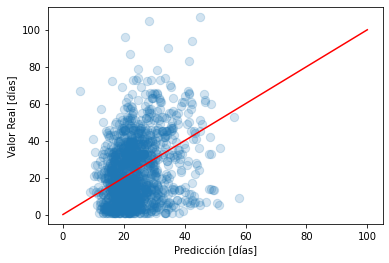

In [74]:
#graficamos los puntos de las predicciones del modelo xgb en funcion de los valores
#reales, tal y como se hizo anteriormente
plt.scatter(preds_xgb, Y_val, alpha=.2, s=70)
#graficamos la recta para poder obtener una idea intuitiva del ajuste
plt.plot([0,100],[0,100], color='red')
plt.xlabel('Predicción [días]')
plt.ylabel('Valor Real [días]');

In [75]:
#calculamos las métricas MAPE y RMSE
print(f'MAPE: {((preds_xgb - Y_val).abs()/Y_val).mean()}')
print(f'RMSE: {(((preds_xgb - Y_val)**2).mean())**.5}')

MAPE: 2.1526434420949325
RMSE: 17.228252913809477


## Report

In [76]:
#generamos las predicciones sobre nuestro conjunto de prueba X_test
preds_test = xgb.predict(X_test)
#obtenemos los indices de X_test
preds_test_index = X_test.index.values

In [77]:
#creamos un dataframe a partir de estos valores
preds_test_df = pd.DataFrame({'car_id': preds_test_index , 'di': preds_test})
#mostramos los primeros cinco elementos
preds_test_df.head(5)

,car_id,di
0,0,18.546770
1,1,15.951382
2,10,16.744326
3,10000,18.194513
4,10001,36.480042


In [78]:
#guardamos nuestro dataframe de predicciones sobre x_test en un archivo .csv
preds_test_df.to_csv('submission.csv', index=None)

In [79]:
preds_test_df

,car_id,di
0,0,18.546770
1,1,15.951382
2,10,16.744326
3,10000,18.194513
4,10001,36.480042
...,...,...
11668,9989,27.958443
11669,9990,14.479628
11670,9991,10.739326
11671,9994,40.508999


Nota: La variacion de XGBoost implementada por scikit (modelo gbr) no es efectiva al considerar max_depth=50, el tiempo de convergencia aumenta y las metricas no mejoran. Por esta razon se incluye unicamente el resultado con max_depth=7

De este pequeño analisis observamos, que como es de esperar, el tiempo de convergencia es diferente para cada modelo. Sin embargo, para ninguno de ellos este tiempo no es excesivamente grande, tomando a lo mas 3 minutos en una maquina con procesador ryzen 5 5600X, 16Gb de memoria RAM y memoria ssd nvme.

De estas pruebas, concluimos que el mejor modelo es XGBoost (implementado por la libreria xgboost), pues los valores MAPE y RMSE son menores comparados con los otros modelos y la visualizacion de la grafica de los valores predichos en funcion a los valores es mucho mas consistente comparada con las graficas de otros modelos.

De esta manera, hemos logrado una diferencia de 0.5070 puntos con respecto ael valor MAPE, que corresponde al 45.0% y una diferencia de 10.831 puntos con respecto al valor RMSE, que corresponde al 62.9%, comparado con el ajuste del codigo original.

Al compararlo con random forest con 1000 estimadores se obtienen las diferencias de 0.4102 (39.9%) y 3.161 (32.2%) puntos en los valores MAPE y RMSE respectivamente

Al compararlo con la variacion XGBoost de scikitlearn se obtienen las diferencias de 0.2494 (28.7%) y 2.484 (27.2%) puntos en los valores MAPE y RMSE respectivamente

# Propuestas / modificaciones

A pesar de que hemos mejorado significativamente el modelo, aún quedan cosas por hacer.

Atendiendo a las preocupaciones de los clientes o interesados, efectivamente existen variables o informacion que podria mejorar el rendimiento del modelo, estas variables son la marca y modelo de los automobiles, que anteriormente se tomó como una sola variable categorica. Por lo que al separar ambas podriamos obtener rendimientos superiores.

Esto lo haremos a continuacion.

In [80]:
#Tomaremos el conjunto X, pues este contiene toda la informacion relevante
#lo modificaremos a modo de que sea posible separar por marca y modelo la informacion
#en car_type, esto se realiza mediante la funcion split.(patron=_)
splited_data_car = X['car_type'].str.split(pat='_',expand=True)

#renombramos las columnas
splited_data_car.columns = ['car_brand', 'car_model']

#mostremos nuestro dataframe que contiene la informacion separada
splited_data_car.head()

,car_brand,car_model
car_id,,
6,lincoln,mkx
8,bmw,x6
11,acura,tlx
12,bmw,serie5
14,audi,a4


In [81]:
#asignamos las dos nuevas columnas a X, el metodo de asignacion es totalmente valido pues no se
#modifico el orden de aparicion
X['car_brand'] = splited_data_car['car_brand']
X['car_model'] = splited_data_car['car_model']

In [82]:
#Ahora, busquemos si este dataframe modificado contiene valores vacios en cada una de sus columnas
#en caso positivo, intercambiemos esos valores por np.nan para posteriormente desecharlos
X.replace('\s+', np.nan, inplace=True, regex=True)

In [83]:
#Veamos la cuenta de la cantidad de valores nan en este nuevo data set
X.isnull().sum()

car_type           0
color              0
year               0
km                 0
average_price      0
transmission       0
body_type          0
car_brand          0
car_model        254
dtype: int64

In [84]:
#puesto a que estamos interesados en las variables categoricas modelo y marca
#no tiene sentido usar valores nan en car_model pues sabemos que la gran mayoria de marcas de
#autos tienen una cantidad determinada de modelos. Este es un error de asignacion y debe ser
#arreglado

#nos deshacemos de las filas que contienen valores np.nan con la funcion dropna
X.dropna(inplace=True)

#comprobamos el cambio
X.isnull().sum()

car_type         0
color            0
year             0
km               0
average_price    0
transmission     0
body_type        0
car_brand        0
car_model        0
dtype: int64

In [85]:
#nos deshacemos de la columna car_type pues ya no es util
X.drop('car_type', axis=1, inplace=True)

#Comprobamos los tipos de X
X.dtypes

color            string
year              int64
km                int64
average_price     int64
transmission     string
body_type        string
car_brand        string
car_model        string
dtype: object

In [86]:
#mostremos nuestro conjunto X modificado
X.head(5)

,color,year,km,average_price,transmission,body_type,car_brand,car_model
car_id,,,,,,,,
6,red,2010,4919877,722375,automatic,sedan,lincoln,mkx
8,blue,2019,27968216,629417,automatic,truck,bmw,x6
11,orange,2017,22473279,914912,automatic,suv,acura,tlx
12,blue,2014,32025699,638187,automatic,sedan,bmw,serie5
14,white,2018,29789949,476254,automatic,suv,audi,a4


In [87]:
#procedamos a crear nuevos conjuntos de validacion y prueba
#A partir de X creamos los conjuntos de entrenamiento y validacion, con las proporciones
#80% y 20% respectivamente, estas porciones se toman aleatoriamente de X con la funcion .sample(frac=porcion)
X_train = X.sample(frac=0.8, random_state=2021)
X_val = X.loc[~X.index.isin(X_train.index)]

#Creamos las variables dependientes de cada uno de los autos, estas variables son solamente
#la cantidad de dias, al conjunto de estas variables lo llamaremos Y_train y Y_test
#y ajustaremos los indices a car_id, y se copiamos los dias a sus respectivos conjuntos (train o val)
#con la funcion .loc[conjunto.indice].dias
Y_train = car_series_days.set_index('car_id').loc[X_train.index].day
Y_val = car_series_days.set_index('car_id').loc[X_val.index].day

In [88]:
#Transformemos nuevamente nuestras variables categoricas en numericas
#tal y como se hizo anteriormente
#Para hacer esto instanciamos la herramienta de scikit LabelEncoder(), la cual puede
#transformar las variables categoricas en numericas de forma automatica
cat_enc = LabelEncoder()

#para poder iterar y transformar las variables presentes en el dataset creamos una
#lista que contiene los nombres de dichas variables, en el codigo original
#el año era tratado como una variable categorica, sin embargo esto no es asi,
#la variable año es discreta y continua, por lo que no lo consideramos en esta
#transformacion
categorical_columns = ['color', 'transmission', 'body_type', 'car_brand','car_model']

#iteramos sobre las columnas de los conjuntos X_val, X_train y X_test para realizar
#dicha transformacion, siendo estas transformacion realizadas al llamar el metodo 
#fit transform de la clase LabelEncoder() 
for col in categorical_columns:
    X_train[col] = cat_enc.fit_transform(X_train.loc[:,col])
    X_val[col] = cat_enc.fit_transform(X_val.loc[:,col])

<ipython-input-88-d5d62fd02e32>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = cat_enc.fit_transform(X_val.loc[:,col])


In [89]:
#REgularicemos y estandaricemos nuestros datos
#designamos una lista con los nombres de las columnas cuyos valores son continuos para poder iterar
#sobre ellas
numerical_data = ['year', 'km', 'average_price']
#estandarizamos los datos correspondientes a las columnas con valores continuos
for col in numerical_data:
    #definimos y ajustamos un escalador, este escalador define la media y varianza de los valores
    #presentes en la columna actual
    scale = StandardScaler()#.fit(X_train[[col]])
    X_train[col] = scale.fit_transform(X_train[[col]])
    X_val[col] = scale.transform(X_val[[col]])
    
#escalamos los datos categoricos al iterar sobre sus columnas
for col in categorical_columns:
     #definimos y ajustamos un normalizador, este normalizador obtiene los maximos y minimos de los valores
    #presentes en la columna actual
    norm = MinMaxScaler().fit(X_train[[col]])
    X_train.loc[:,col] = norm.transform(X_train[[col]])
    X_val.loc[:,col] = norm.transform(X_val[[col]])

<ipython-input-89-93c38dd4cf5e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = scale.transform(X_val[[col]])
<ipython-input-89-93c38dd4cf5e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = scale.transform(X_val[[col]])
<ipython-input-89-93c38dd4cf5e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

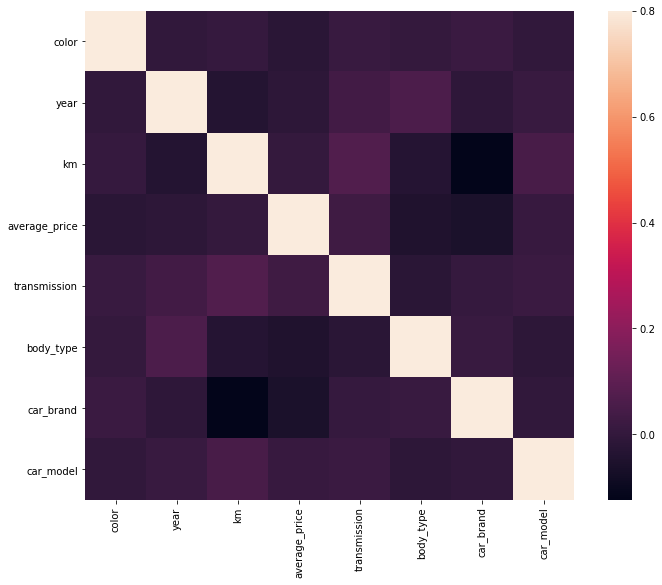

In [90]:
#visualicemos ahora el mapa de correlaciones, esto es especialmente util para conocer
#la correlacion entre los datos, que en algunas ocasiones nos permite reducir la dimensionalidad
corrmat = X_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [91]:
#instanciamos el modelo xgboost, con n_estimators=1000 para realizar comparaciones justas
xgb_new = xgboost.XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
#Ajustamos el modelo xgb usando los datos de entrenamiento
xgb_new.fit(X_train, Y_train)
#realizamos la predicciones sobre el conjunto de validacion
preds_xgb_new = xgb_new.predict(X_val)

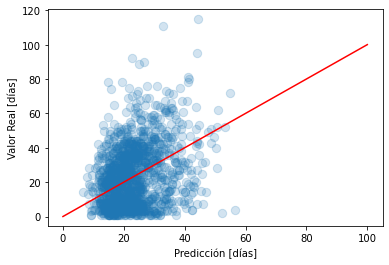

In [92]:
#graficamos los puntos de las predicciones del modelo xgb en funcion de los valores
#reales, tal y como se hizo anteriormente
plt.scatter(preds_xgb_new, Y_val, alpha=.2, s=70)
#graficamos la recta para poder obtener una idea intuitiva del ajuste
plt.plot([0,100],[0,100], color='red')
plt.xlabel('Predicción [días]')
plt.ylabel('Valor Real [días]');

In [93]:
#calculamos las métricas MAPE y RMSE
print(f'MAPE: {((preds_xgb_new - Y_val).abs()/Y_val).mean()}')
print(f'RMSE: {(((preds_xgb_new - Y_val)**2).mean())**.5}')

MAPE: 1.987035339124427
RMSE: 17.219049956206348


In [94]:
x = X_train.drop(columns={'average_price', 'transmission', 'body_type'})
x_vcalid = X_val.drop(columns={'average_price', 'transmission', 'body_type'})

In [95]:
#instanciamos el modelo xgboost, con n_estimators=1000 para realizar comparaciones justas
xgb_new1 = xgboost.XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
#Ajustamos el modelo xgb usando los datos de entrenamiento
xgb_new1.fit(x, Y_train)
#realizamos la predicciones sobre el conjunto de validacion
preds_xgb_new1 = xgb_new1.predict(x_vcalid)

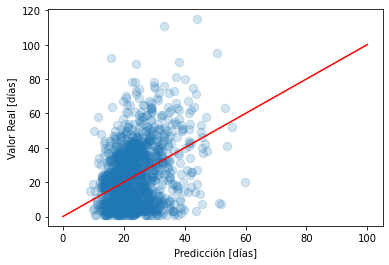

In [96]:
#graficamos los puntos de las predicciones del modelo xgb en funcion de los valores
#reales, tal y como se hizo anteriormente
plt.scatter(preds_xgb_new1, Y_val, alpha=.2, s=70)
#graficamos la recta para poder obtener una idea intuitiva del ajuste
plt.plot([0,100],[0,100], color='red')
plt.xlabel('Predicción [días]')
plt.ylabel('Valor Real [días]');

In [97]:
#calculamos las métricas MAPE y RMSE
print(f'MAPE: {((preds_xgb_new1 - Y_val).abs()/Y_val).mean()}')
print(f'RMSE: {(((preds_xgb_new1 - Y_val)**2).mean())**.5}')

MAPE: 2.02954340973942
RMSE: 17.08317402697853


De aquí que la hipotesis de separar la informacion por marca y modelo debe ser desechada, pues los resultados obtenidos son ligeramente peores que cuando se considera marca y modelo como una sola entidad

## Palabras finales / conclusiones

* 1) El análisis, original, presentado a los clientes efectivamente subestimaba el valor DI, pues el modelo de regresion (Random Forest) estaba implementando un único árbol o estimador, lo cual no logra producir resultados óptimos. Esto logró subsanarse al incrementar el valor de los estimadores, produciendose así errores menores que a los originales y consistentes.

* 1.a) En el código original se cometieron varios errores, siendo el mayor la suposición de que todos los datasets se encontraban limpios y sin errores.  Sin embargo, esto no es así, por lo que en este código NO realizamos estas suposiciones y procedimos a limpiar los datasets. Excepto para aquellos casos para los caules no tenemos acceso directo, por ejemplo pueden presentarse en estos datasets un modelo o marca de auto que no existe. Para solucionar este tipo de problemas se requiere de un catalogo generalizado.

* 2) Este código se desarrolló pensando en los clientes, quiénes podrían no tener experiencia en la programación, por esta razón, cada linea de codigo se encuentra comentada, procurando ser breves y claros.

* 3) Hemos demostrado que agregar más información, disponible, en estos datasets, tal como separar la descripcion de cada auto en modelo y marca, incrementa el error a comparación de cuando estas características se consideran como un sólo ente. Por lo que para mejorar el modelo, podría agregarse las variaciones de precio, hasta que un auto fue finalmente vendido, además podría agregarse un estudo que relacione las preferencias globales del conjunto de clientes, con respecto a modelo y marca, siendo esta una posible variable de importancia.

* 3.1) A diferencia de agregar nuevas variables a nuestros datos, también, para mejorar el modelo, pueden implementarse técnicas de aprendizaje de máquinas que permiten esto. Como sugerencia: Puede realizarse un ajuste de hiperparámetros sobre el mejor modelo. Agregarse la técnica de validación cruzada, estudiar los mejores métodos de regularización para el problema en sí y ademas agregarse más métricas de evaluación para tener una visión más general.

* El reporte de clasificación fue generado usando el mejor modelo, que en este caso fue XGBoost.